# S-Learner Tutorial

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import pyreadr
import random

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from causalml.inference.meta import BaseSClassifier


In [12]:
data_read = pyreadr.read_r('/Users/pbrendel/projects/multibias/data/df_uc_source.rda')
df = data_read['df_uc_source']

df.head()

,X_bi,X_cont,Y_bi,Y_cont,C1,C2,C3,U
0,0,2.22,0,4.01,0,0,1,1
1,1,2.42,0,4.98,1,0,0,1
2,0,0.98,0,1.37,1,0,1,0
3,0,3.33,0,3.87,1,1,1,1
4,0,4.09,0,4.27,1,1,1,1


In [ ]:
Y = df['Y_bi']
T = df['X_bi']
X = df[['C1', 'C2', 'C3', 'U']]

In [105]:
random.seed(123)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2)

# Obtain CATE in train data

In [106]:
learner = LogisticRegression(penalty=None, solver='lbfgs')
slearner = BaseSClassifier(learner=learner)

In [107]:
slearner.fit(X=X_train, treatment=T_train, y=Y_train)
slearner.estimate_ate(
  X=X_train,
  treatment=T_train,
  y=Y_train,
  return_ci=True,
  bootstrap_ci=True,
  bootstrap_size=1000
  )


100%|██████████| 1000/1000 [00:04<00:00, 247.93it/s]


(array([0.10096941]), array([0.05185725]), array([0.15505866]))

In [ ]:
# output model coefs

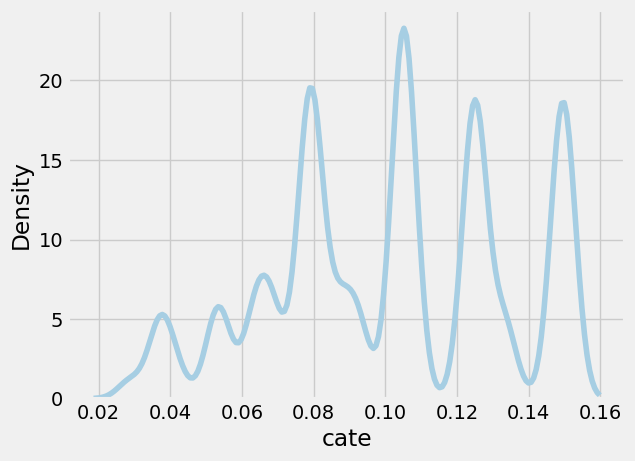

In [108]:
cate = slearner.predict(X_train)
sns.kdeplot(data=pd.DataFrame({'cate': cate.reshape(-1)}), x="cate");


# Compare to CATE in test data

In [109]:
slearner.estimate_ate(X=X_test, treatment=T_test, y=Y_test, return_ci=True, bootstrap_ci=True, bootstrap_size=1000)

100%|██████████| 1000/1000 [00:02<00:00, 474.36it/s]


(array([0.10550383]), array([0.05277566]), array([0.15993162]))

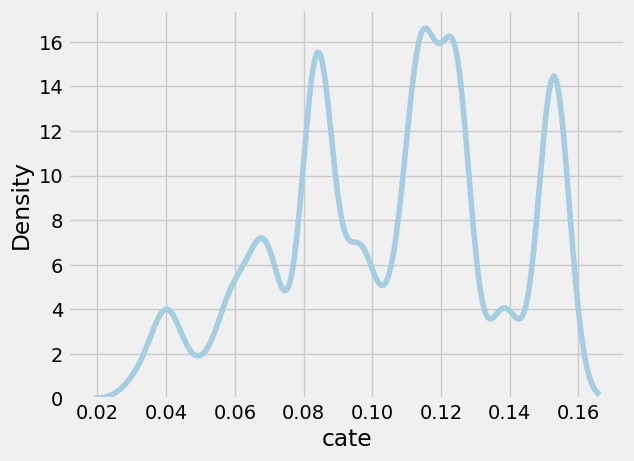

In [110]:
cate = slearner.predict(X_test)
sns.kdeplot(data=pd.DataFrame({'cate': cate.reshape(-1)}), x="cate");

# Assess heterogeneity

In [ ]:
# plot uplift

In [ ]:
# feature importance